In [1]:
import os
from collections import defaultdict
import numpy as np

log_dir = './logs'
experiment_logs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for filename in os.listdir(log_dir):
    if filename.endswith('.log'):
        parts = filename.split('-')
        method = '-'.join(parts[0:1])            
        experiment_name = '-'.join(parts[1:2])
        dataset = '-'.join(parts[2:3])
        nlist = '-'.join(parts[3:4])
        k = int('-'.join(parts[4:5]))
        if method == "ConANN":
            error = float(parts[5:6][0])
        else:
            error = float(parts[5:6][0][:-4])

        with open(os.path.join(log_dir, filename), 'r') as file:
            experiment_logs[experiment_name][method][dataset][k][error] = [float(line.strip()) for line in file.readlines()]

datasets = [j for j in experiment_logs['efficiency']['ConANN'].keys()]
print(datasets)
print(experiment_logs['error']['ConANN']['deep10M'][1000][0.2][:10])

data = experiment_logs['error']['ConANN']['deep10M'][100][0.1]
average = np.mean(data)
print(average)

['gist', 'sift1M', 'deep10M', 'bert', 'fasttext']
[0.47, 0.299, 0.184, 0.264, 0.305, 0.113, 0.5, 0.321, 0.053, 0.101]
0.100407499195


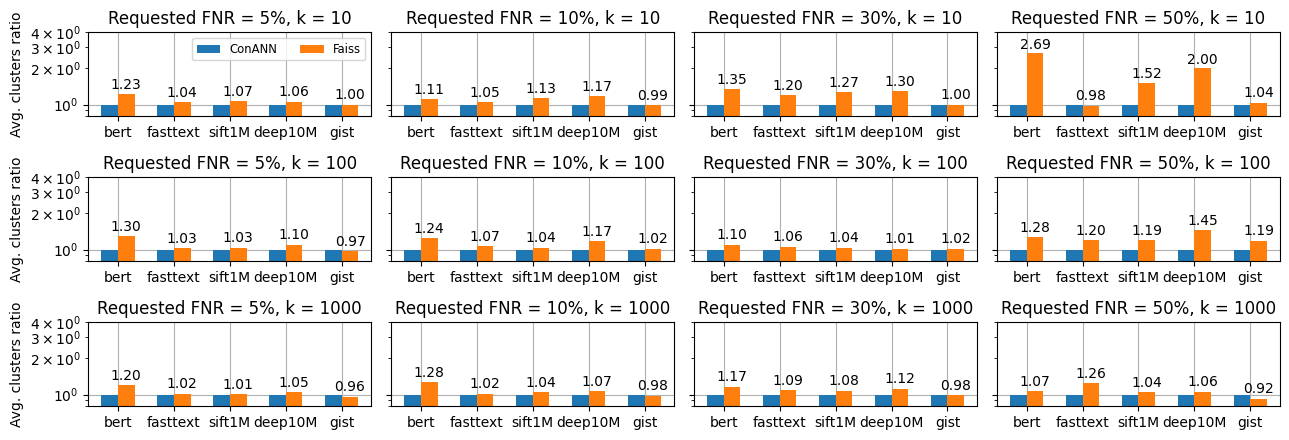

In [52]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

experiment_name = 'efficiency'
k_values = [10, 100, 1000]  # List of k values
error_values = [0.05, 0.1, 0.3, 0.5]  # List of error values
target_datasets = ['bert', 'fasttext', 'sift1M', 'deep10M', 'gist']
methods = ['ConANN', 'Faiss']
fig, axes = plt.subplots(len(k_values), len(error_values), figsize=(13, len(k_values) * 1.5), sharey=True)

for k_idx, k_value in enumerate(k_values):
    for error_idx, error_value in enumerate(error_values):
        ax = axes[k_idx, error_idx]
        
        clusters_ratio_per_method = {dataset: [] for dataset in target_datasets}
        method_averages = {method: [] for method in methods}

        for target_dataset in target_datasets:
            data = {}
            conann_avg = None  # Store ConANN average for the current dataset
            for method in experiment_logs[experiment_name]:
                for dataset in experiment_logs[experiment_name][method]:
                    if dataset == target_dataset:
                        try:
                            values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                            if method == 'ConANN':
                                count_minus_one = values.count(-1)
                                values = [v for v in values if v != -1]
                            data[method] = np.sort(values)
                        except KeyError:
                            continue

            if 'ConANN' in data:
                conann_avg = np.mean(data['ConANN'])

            # Compute clusters ratio for each method based on the ConANN baseline
            for method in methods:
                if method in data and conann_avg is not None:
                    avg_clusters = np.mean(data[method])
                    ratio = avg_clusters / conann_avg
                    clusters_ratio_per_method[target_dataset].append(ratio)
                    method_averages[method].append(avg_clusters)

        bar_width = 0.3
        index = np.arange(len(target_datasets))

        for i, method in enumerate(methods):
            bars = ax.bar(index + i * bar_width, 
                          [clusters_ratio_per_method[dataset][i] for dataset in target_datasets],
                          bar_width, label=method)

            if method == 'Faiss':
                for j, bar in enumerate(bars):
                    ratio_value = clusters_ratio_per_method[target_datasets[j]][i]
                    ax.text(bar.get_x() + bar.get_width() / 2, 
                            bar.get_height() + 0.05,  
                            f'{ratio_value:.2f}',  
                            ha='center', va='bottom', fontsize=10)

        ax.set_title(f'Requested FNR = {int(error_value * 100)}%, k = {k_value}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(target_datasets)
        ax.grid(True)
        ax.set_ylim(0.8, 4)
        ax.set_yscale('log')
        ax.set_axisbelow(True)

        if error_idx == 0:
            ax.set_ylabel('Avg. clusters ratio')

axes[0, 0].legend(fontsize='small', loc='upper right', ncol=2)

plt.tight_layout()
plt.savefig(f'efficiency_all.pdf', format='pdf')
plt.show()
